In [1]:
import os
import pickle 
import numpy as np
import pennylane as qml
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt

In [2]:
side = 51
num_qubits = 8

In [3]:
# Create meshgrid of the parameter space
def diagonalize_H(H_matrix):
    """Returns the lowest eigenvector of the Hamiltonian matrix."""
    _, psi = jnp.linalg.eigh(H_matrix)  # Compute eigenvalues and eigenvectors
    return jnp.array(psi[:, 0], dtype=jnp.complex64)  # Return the ground state

def get_H(num_spins, k, h):
    """Construction function the ANNNI Hamiltonian (J=1)"""

    # Interaction between spins (neighbouring):
    H = -1 * (qml.PauliX(0) @ qml.PauliX(1))
    for i in range(1, num_spins - 1):
        H = H  - (qml.PauliX(i) @ qml.PauliX(i + 1))

    # Interaction between spins (next-neighbouring):
    for i in range(0, num_spins - 2):
        H = H + k * (qml.PauliX(i) @ qml.PauliX(i + 2))

    # Interaction of the spins with the magnetic field
    for i in range(0, num_spins):
        H = H - h * qml.PauliZ(i)

    return H

def fidelity(psi: jnp.ndarray, phi: jnp.ndarray) -> jnp.ndarray:
    inner_product = jnp.vdot(psi, phi)
    return jnp.abs(inner_product)**2

In [4]:
# p_chi = [2, 4, 8, 16, 32, 64]
p_chi = [2, 4, 8]
for chi in p_chi:
    filename = f"./mps/ANNNI_L{num_qubits}_X{chi}"
    if os.path.exists(filename):
        print(f"Skipping chi={chi}, file already exists.")
        continue
    os.system(f"python ../src/PhaseEstimation/dmrg.py --L {num_qubits} --side {side} --chi {chi} --path './mps/'")

Skipping chi=2, file already exists.
Skipping chi=4, file already exists.
Skipping chi=8, file already exists.


In [6]:
with open(f"./mps/ANNNI_L{num_qubits}_X2", "rb") as f:
    data = pickle.load(f)
    
points = list(data.keys())
p_k = sorted(set(x for x, _ in points))
p_h = sorted(set(y for _, y in points))

In [7]:
# Preallocate arrays for Hamiltonian matrices and phase labels.
H_matrices = np.empty((len(p_k), len(p_h), 2**num_qubits, 2**num_qubits))
phases = np.empty((len(p_k), len(p_h)), dtype=int)

for x, k in enumerate(p_k):
    for y, h in enumerate(p_h):
        H_matrices[y, x] = np.real(qml.matrix(get_H(num_qubits, k, h))) # Get Hamiltonian matrix

# Vectorized diagonalization
pp_psi = vmap(vmap(diagonalize_H))(H_matrices)

# Create the dictionary from the vmapped outputs
psi_dict = {
    (float(p_k[x]), float(p_h[y])): pp_psi[y, x]
    for y in range(len(p_h))
    for x in range(len(p_k))
}

In [8]:
def contract_mps(mps):
    # Ensure all tensors are in shape (left, phys, right)
    tensors = []
    for A in mps:
        A = np.array(A)
        if A.ndim == 2:  # likely shape (phys, bond)
            A = A[None, :, :]  # add left dim
        elif A.ndim == 3 and A.shape[0] == 1:  # shape (1, phys, bond)
            pass
        tensors.append(A)

    state = tensors[0]
    for A in tensors[1:]:
        # Contract the right bond of `state` with the left bond of `A`
        state = np.tensordot(state, A, axes=([-1], [0]))
        # Combine physical dimensions
        phys_dim = state.shape[1] * state.shape[2]
        state = state.reshape(state.shape[0], phys_dim, -1)

    # The result is of shape (1, 2**n, 1), squeeze to get 1D state vector
    return state.reshape(-1)

# Example usage
wavefunction = contract_mps(data[p_k[5], p_h[5]][1])

In [9]:
fidelity(contract_mps(data[p_k[5], p_h[5]][1]), psi_dict[p_k[5], p_h[5]])

Array(0.9999316, dtype=float32)

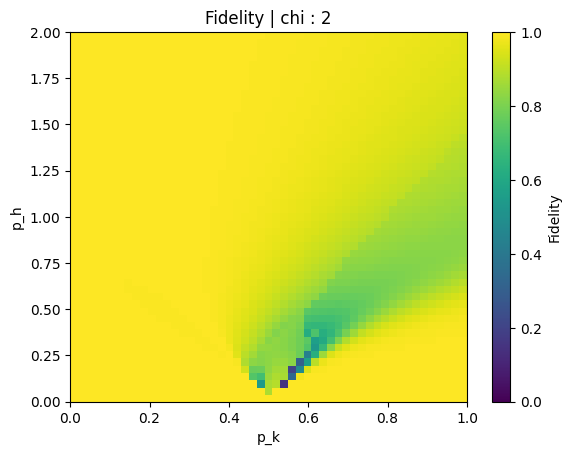

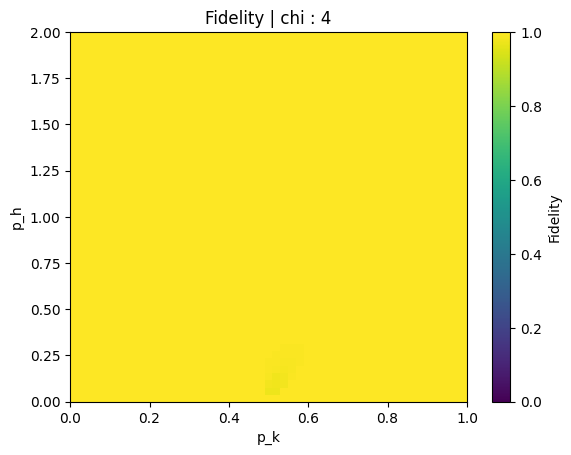

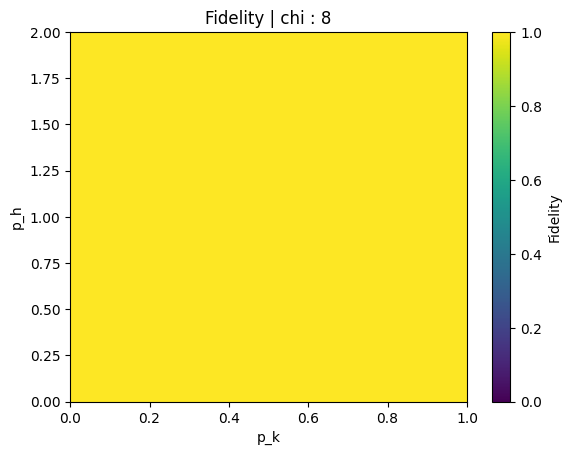

In [25]:
for chi in p_chi:
    with open(f"./mps/ANNNI_L{num_qubits}_X{chi}", "rb") as f:
        data = pickle.load(f)
        
    points = list(data.keys())

    # Create a 2D array to store fidelity values
    fidelity_map = np.zeros((len(p_h), len(p_k)))

    # Fill the array
    for i, h in enumerate(p_h):
        for j, k in enumerate(p_k):
            mps = contract_mps(data[k, h][1])
            target = psi_dict[k, h]
            fidelity_map[i, j] = fidelity(mps, target)
            if k > .8 and h < .2:
                fidelity_map[i, j] = 1
    fidelity_map[fidelity_map < .1] = 1
    fidelity_map[0, :] = 1


    # Display with imshow
    plt.imshow(fidelity_map, origin='lower', extent=(min(p_k), max(p_k), min(p_h), max(p_h)),
               aspect='auto', cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='Fidelity')
    plt.xlabel('p_k')
    plt.ylabel('p_h')
    plt.title(f'Fidelity | chi : {chi}')
    plt.show()